<a href="https://colab.research.google.com/github/straxFromIbr/Pics2LGate/blob/main/Pic2LGate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 画像から回路の構造を抽出

In [ ]:
!wget https://raw.githubusercontent.com/straxFromIbr/Pics2LGate/main/image.jpg &>/dev/null

In [2]:
import numpy as np

import matplotlib.pyplot as plt

from skimage import io as skio
from skimage import transform
from skimage import morphology
from skimage import filters
from skimage import feature
from skimage import draw
from skimage import measure


## 画像から回路図
### 指針

### 画像の読み込み
- ./image.jpgを読み込む
- そのままだと大きすぎる(998, 2167, 3)ので、1/5に縮小
- 加えて枠も表示([Ymin, Ymax, Xmin, Xmax]の順番)


In [7]:
def draw_bbox(image, bbox, color=0):
    """
    * 枠線描画関数
    """
    with_boxes = np.copy(image)
    r = [bbox[0], bbox[1], bbox[1], bbox[0], bbox[0]]
    c = [bbox[3], bbox[3], bbox[2], bbox[2], bbox[3]]
    rr, cc = draw.polygon_perimeter(r, c, shape=image.shape)
    with_boxes[rr, cc] = color
    return with_boxes


def draw_rect(image, bbox, color=0):
    """
    * 枠線の中をcolorで塗りつぶす関数
    """
    with_boxes = np.copy(image)
    r = [bbox[0], bbox[1], bbox[1], bbox[0], bbox[0]]
    c = [bbox[3], bbox[3], bbox[2], bbox[2], bbox[3]]
    rr, cc = draw.polygon(r, c, shape=image.shape)
    with_boxes[rr, cc] = color
    return with_boxes


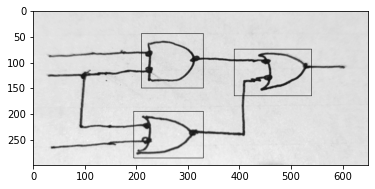

In [16]:
# * 読み込み & 縮小
org_image = skio.imread("./image.jpg", as_gray=True)
scale = 0.3
org_image = transform.rescale(org_image, scale)
# * 枠線の座標

BBOX_AND1 = np.array((150, 500, 700, 1100)) * scale
BBOX_OR1 = np.array((650, 950, 650, 1100)) * scale
BBOX_OR2 = np.array((250, 550, 1300, 1800)) * scale

image_with_bbox = draw_bbox(org_image, BBOX_AND1)
image_with_bbox = draw_bbox(image_with_bbox, BBOX_OR1)
image_with_bbox = draw_bbox(image_with_bbox, BBOX_OR2)

plt.imshow(image_with_bbox, cmap="gray")
plt.show()


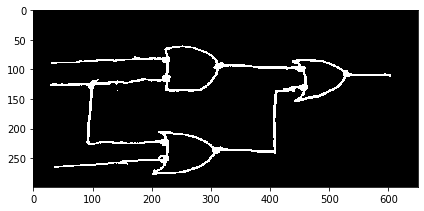

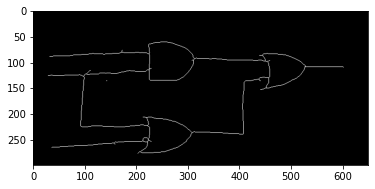

In [17]:
# * 二値化
thr = filters.threshold_otsu(org_image)
bin_image = org_image < thr
skio.imshow(bin_image, cmap="gray")
plt.show()

# * 細線化
skl_image = morphology.skeletonize(bin_image)
plt.imshow(skl_image, cmap="gray")
plt.show()


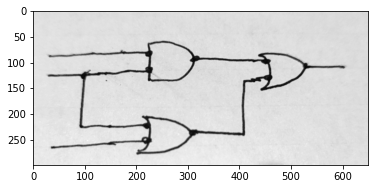

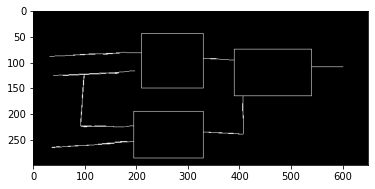

In [26]:
# * 回路部分を塗りつぶす
image = draw_rect(skl_image, BBOX_AND1)
image = draw_rect(image, BBOX_OR1)
image = draw_rect(image, BBOX_OR2)

# * ハフ変換をして直線を抽出
# * ここのパラメータは要調整
lines = transform.probabilistic_hough_line(
    image, threshold=15, line_length=15, line_gap=20
)

canvas = np.zeros_like(image)
for line in lines:
    # * 直線をcanvasに描画 
    # lineに直線の始点(x0, y0)と終点(x1, y1)が入っている
    # この座標をもとに回路生成?
    x0, y0 = line[0]
    x1, y1 = line[1]
    yy, xx = draw.line(y0, x0, y1, x1)
    canvas[yy, xx] = 1

# * 素子の枠線を描画
canvas = draw_bbox(canvas, BBOX_AND1, color=1)
canvas = draw_bbox(canvas, BBOX_OR1, color=1)
canvas = draw_bbox(canvas, BBOX_OR2, color=1)

plt.imshow(org_image, cmap="gray")
plt.show()
plt.imshow(canvas, cmap="gray")
plt.show()
